In [1]:
# مصطفى أنور محمد قناوي
# محمود علي عاشور
# محمود رجب مهدي 
# أحمد سعد عبد العزيز
# محمد راضي عبد القادر

In [2]:
%matplotlib inline

import matplotlib
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from sklearn.cluster import SpectralClustering
import warnings

In [3]:
df = pd.read_csv("musae_ENGB_edges.csv")

In [4]:
df.head()

from    to
0  6194   255
1  6194   980
2  6194  2992
3  6194  2507
4  6194   986

In [5]:
G = nx.from_pandas_edgelist(df,source="from",target="to")

In [6]:
type(G)

networkx.classes.graph.Graph

In [7]:
nx.info(G)

'Graph with 7126 nodes and 35324 edges'

In [8]:
print(nx.is_directed(G))

False


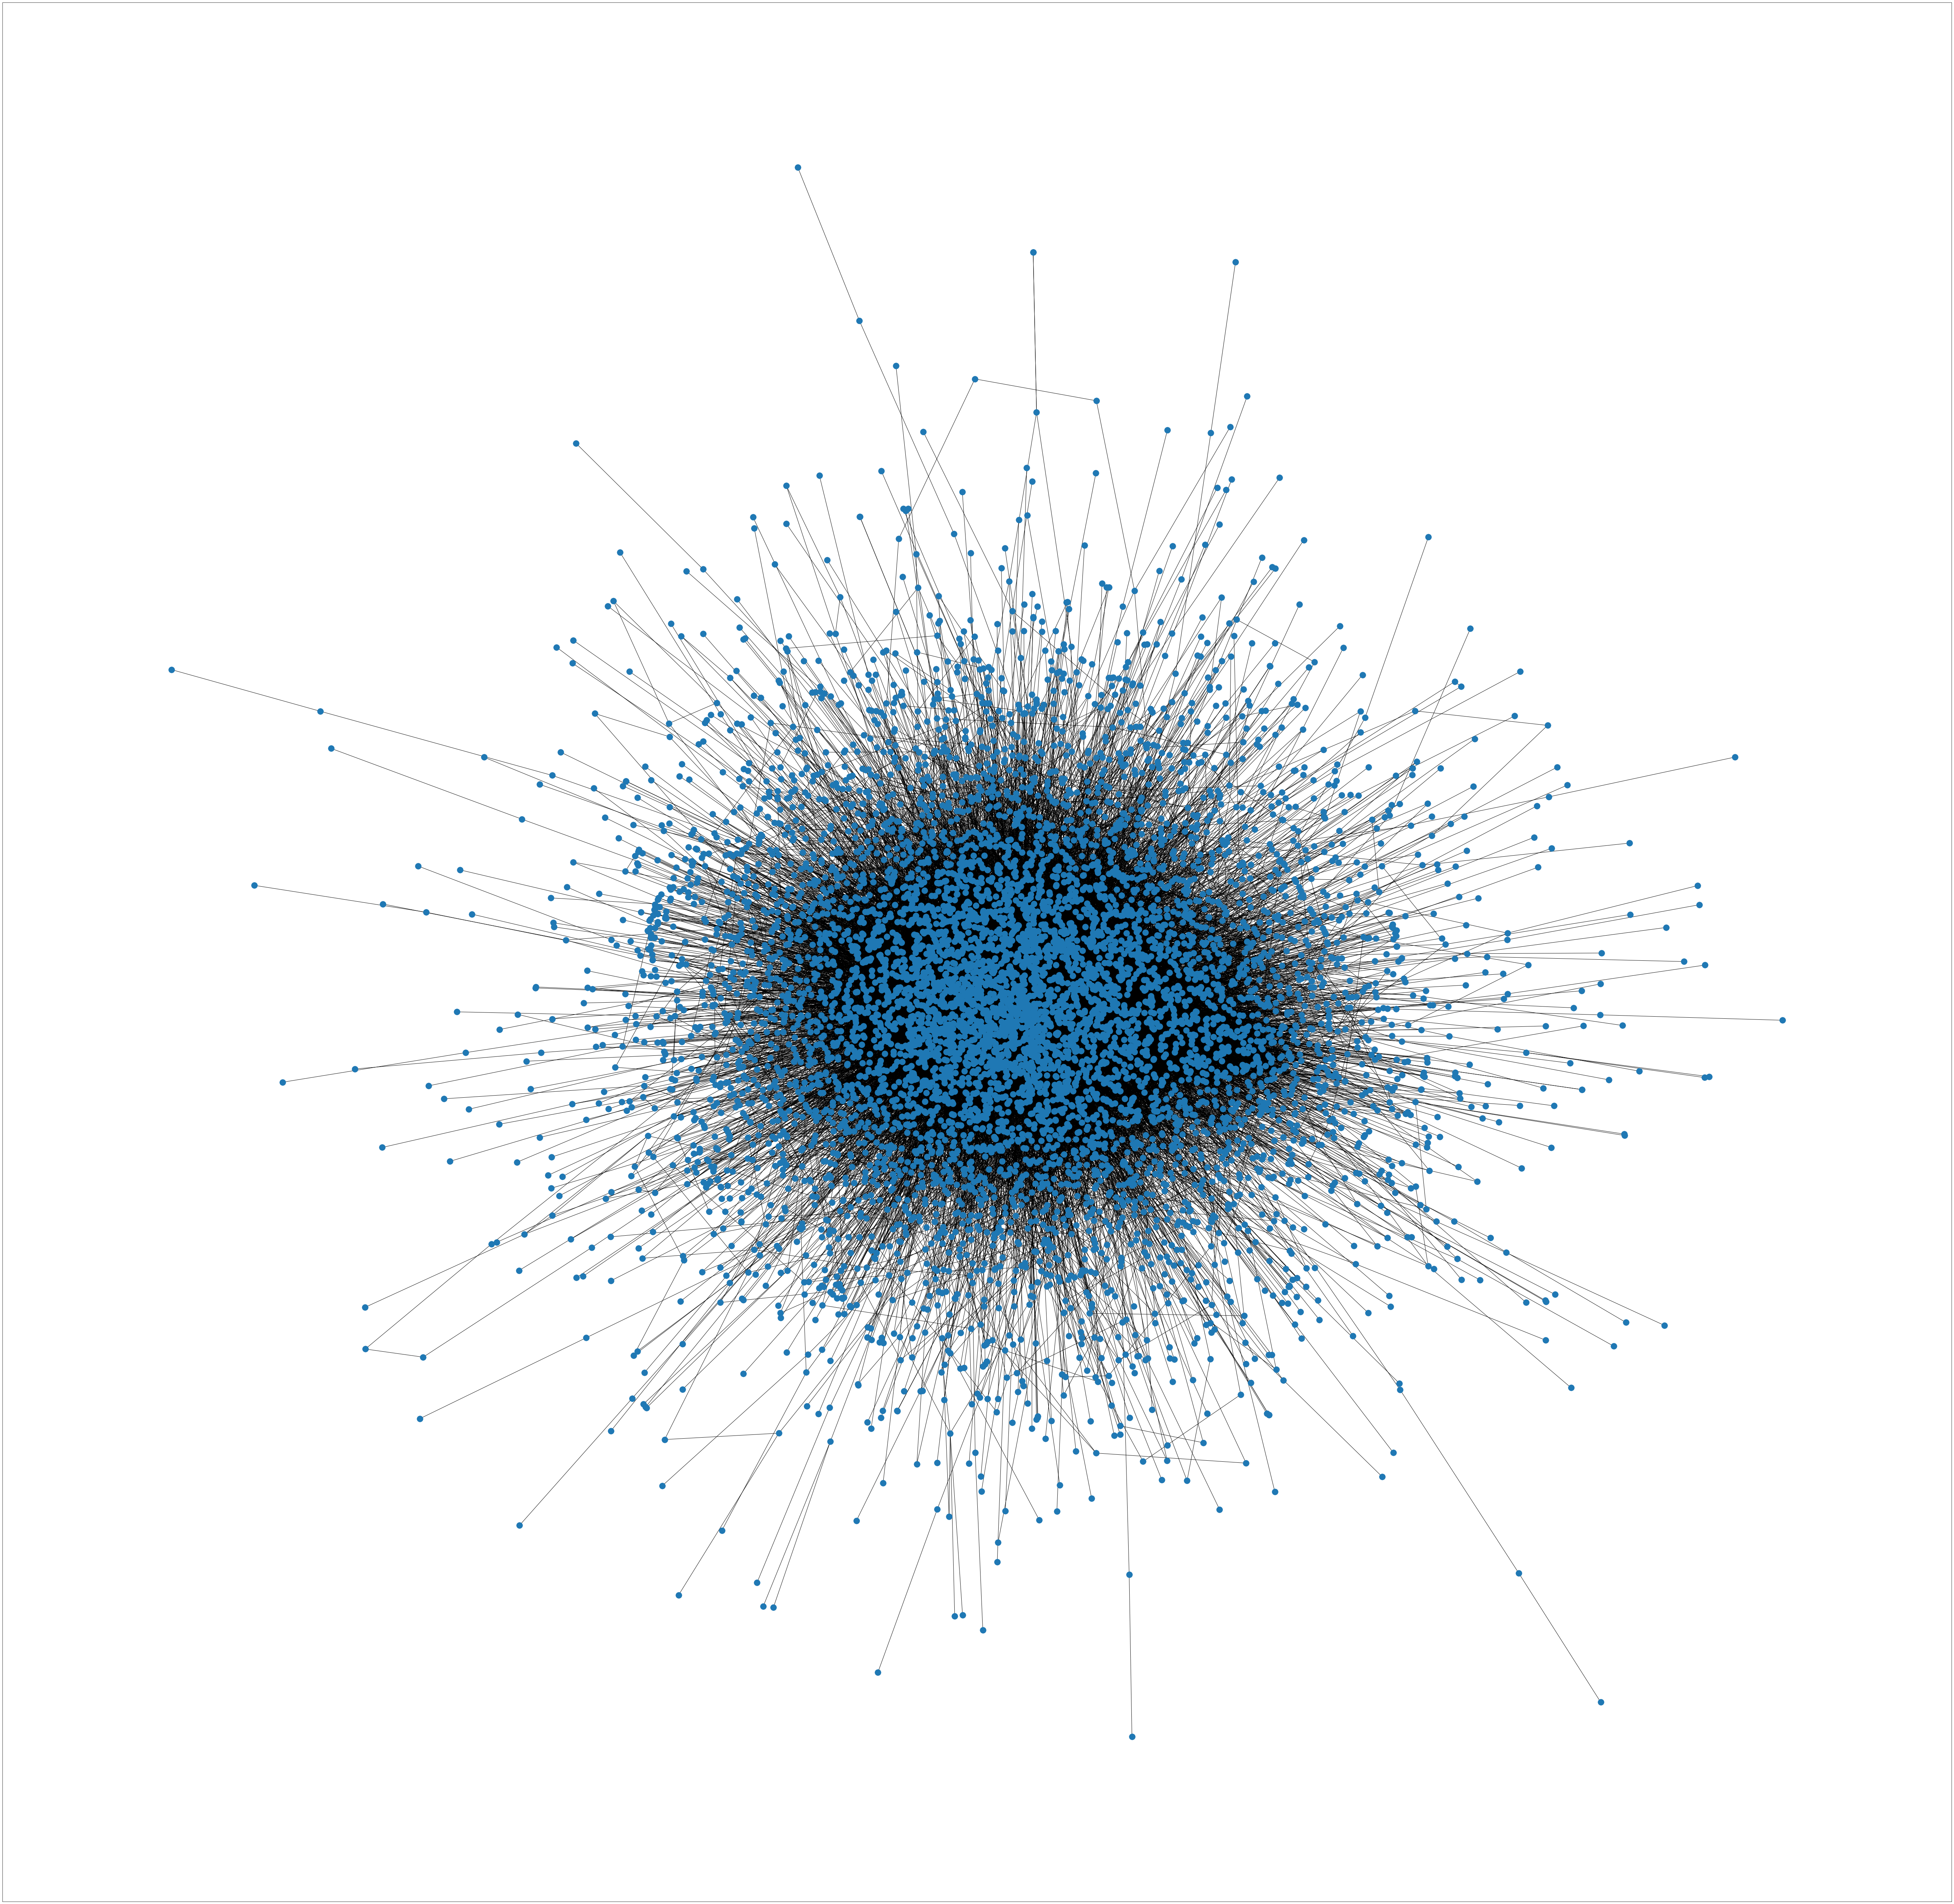

In [9]:
plt.figure(figsize=(100,100))
nx.draw_networkx(G,with_labels=False)
plt.show()

In [10]:
def find_degree(G):
   return dict(G.degree())

degree = {
  'G':find_degree(G)
}

def degree_hist(G_degree):
  return plt.hist(list(G_degree.values()),sorted(set(G_degree.values())), rwidth=0.5, align="left")

mean_degree = {
  'G':np.mean(list(degree['G'].values()))
}

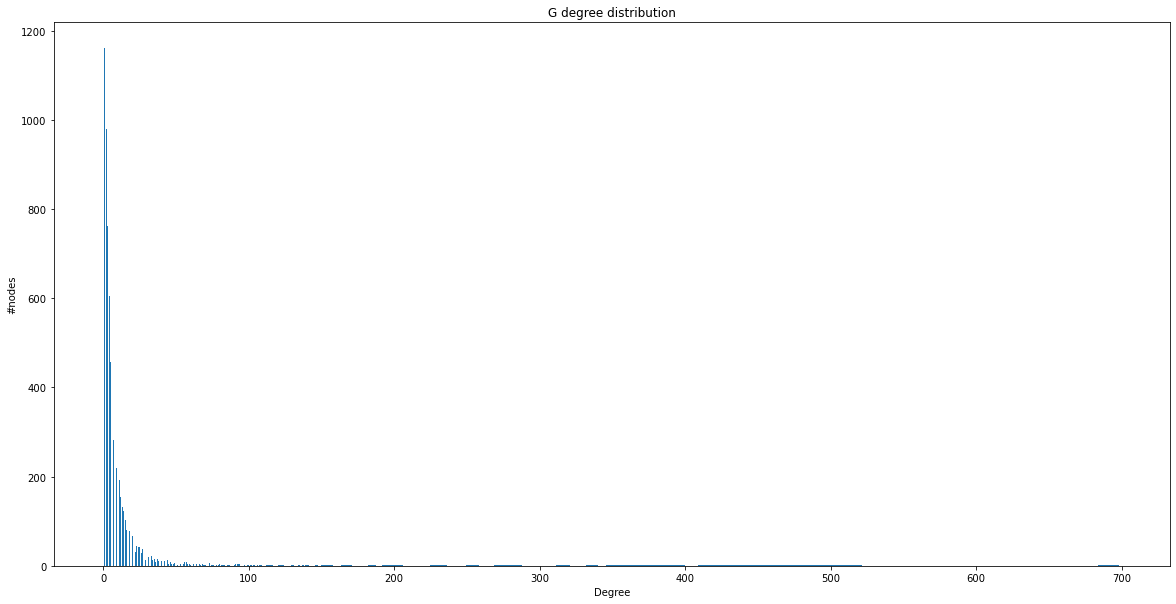

In [11]:
for key in degree.keys():
  plt.figure(figsize=(20,10))
  plt.title(key+" degree distribution")
  plt.xlabel("Degree")
  plt.ylabel("#nodes")
  degree_hist(degree[key])

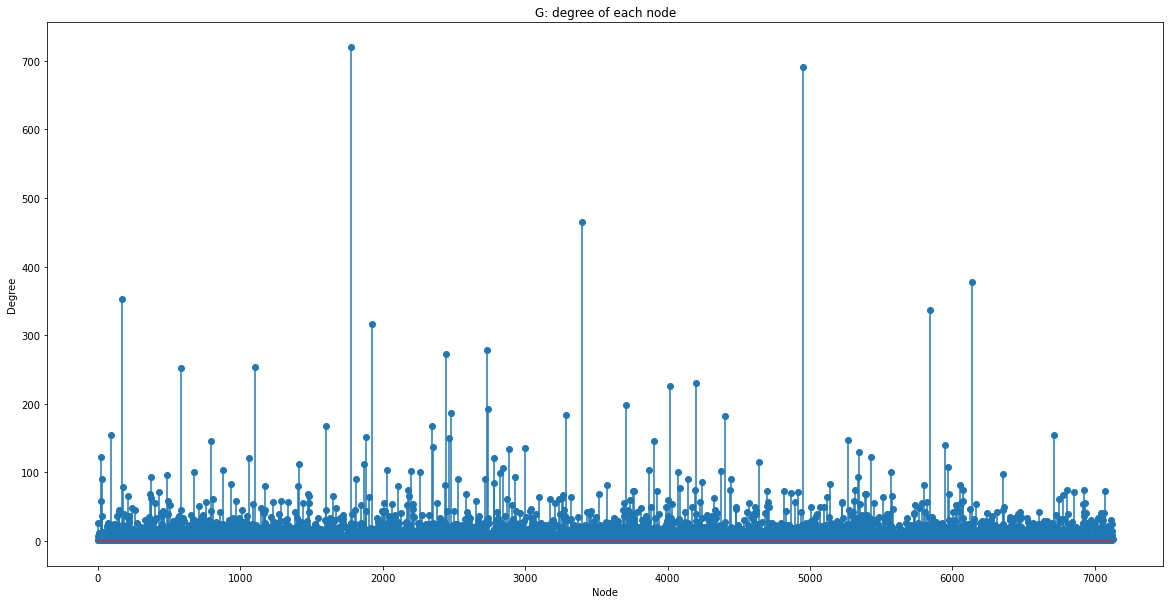

In [12]:
for key in degree.keys():
  plt.figure(figsize=(20,10))
  plt.title(key+": degree of each node")
  plt.xlabel("Node")
  plt.ylabel("Degree")
  plt.stem(degree[key].keys(), degree[key].values())

In [13]:
for key in mean_degree.keys():
  mean = mean_degree[key]
  print("The average degree is: %f" %mean)

The average degree is: 9.914117


In [14]:
def clust_coef(G):
  return nx.clustering(G)

cc = {
  'G':clust_coef(G)
}


def cc_hist(G_cc):
  return plt.hist(list(G_cc.values()),sorted(set(G_cc.values())), rwidth=0.5, align="left")

mean_cc = {
  'G':np.mean(list(cc['G'].values()))
}

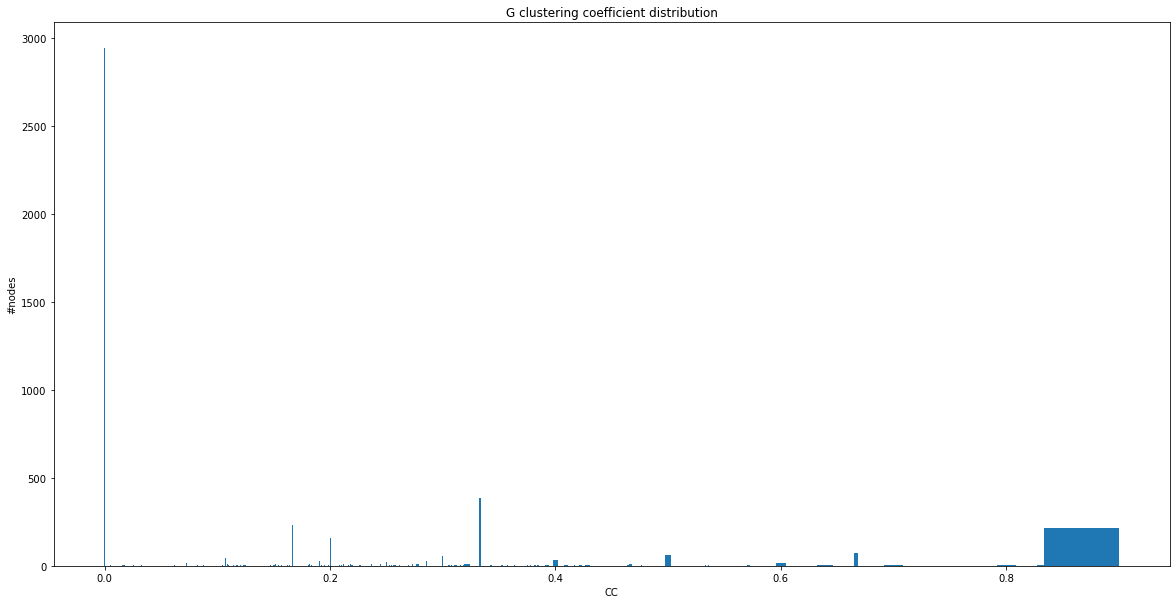

In [15]:
for key in cc.keys():
  plt.figure(figsize=(20,10))
  plt.title(key+" clustering coefficient distribution")
  plt.xlabel("CC")
  plt.ylabel("#nodes")
  degree_hist(cc[key])

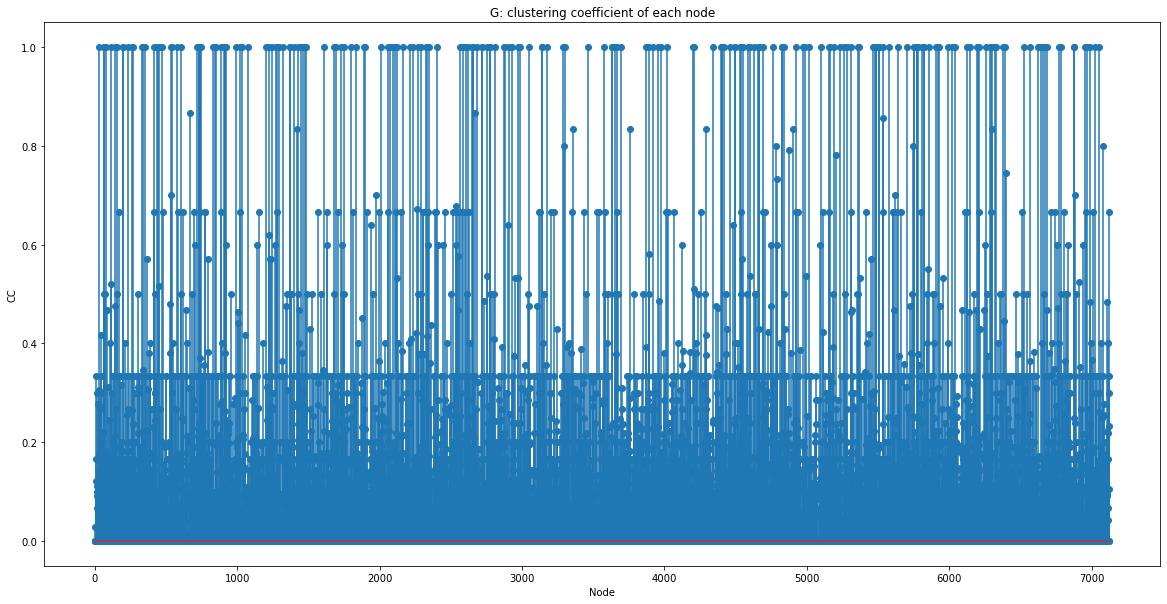

In [16]:
for key in cc.keys():
  plt.figure(figsize=(20,10))
  plt.title(key+": clustering coefficient of each node")
  plt.xlabel("Node")
  plt.ylabel("CC")
  plt.stem(cc[key].keys(), cc[key].values())

In [17]:
for key in mean_cc.keys():
  mean = mean_cc[key]
  print("The average clustering coefficient is: %f" %mean)

The average clustering coefficient is: 0.130928


In [18]:
def ego_centrality(G):
  ego_centr = dict()

  for i in range (0,len(G)):
    ego_net = nx.ego_graph(G,i)
    A = nx.adjacency_matrix(ego_net).todense()
    ones = np.ones(A.shape)
    A_sq = np.linalg.matrix_power(A,2)
    A_ego = np.multiply(A_sq, ones - A)
    A_ego = np.triu(A_ego,1)
    A_ego = A_ego[np.nonzero(A_ego)]
    A_ego = 1/A_ego
    ego_centr[i] = np.sum(A_ego)

  return ego_centr

ebtw = {
  'G':ego_centrality(G)
}

def egobtw_hist(G_ebtw): 
  return plt.hist(list(G_ebtw.values()),sorted(set(G_ebtw.values())), rwidth=0.5, align="left")

mean_ebtw = {
  'G':np.mean(list(ebtw['G'].values()))
}

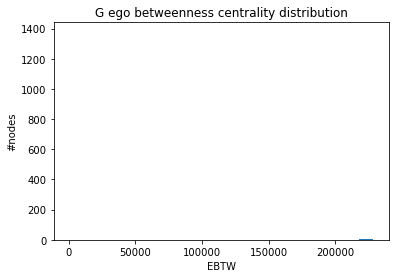

In [19]:
for key in ebtw.keys():
  plt.figure()
  plt.title(key+" ego betweenness centrality distribution")
  plt.xlabel("EBTW")
  plt.ylabel("#nodes")
  degree_hist(ebtw[key])

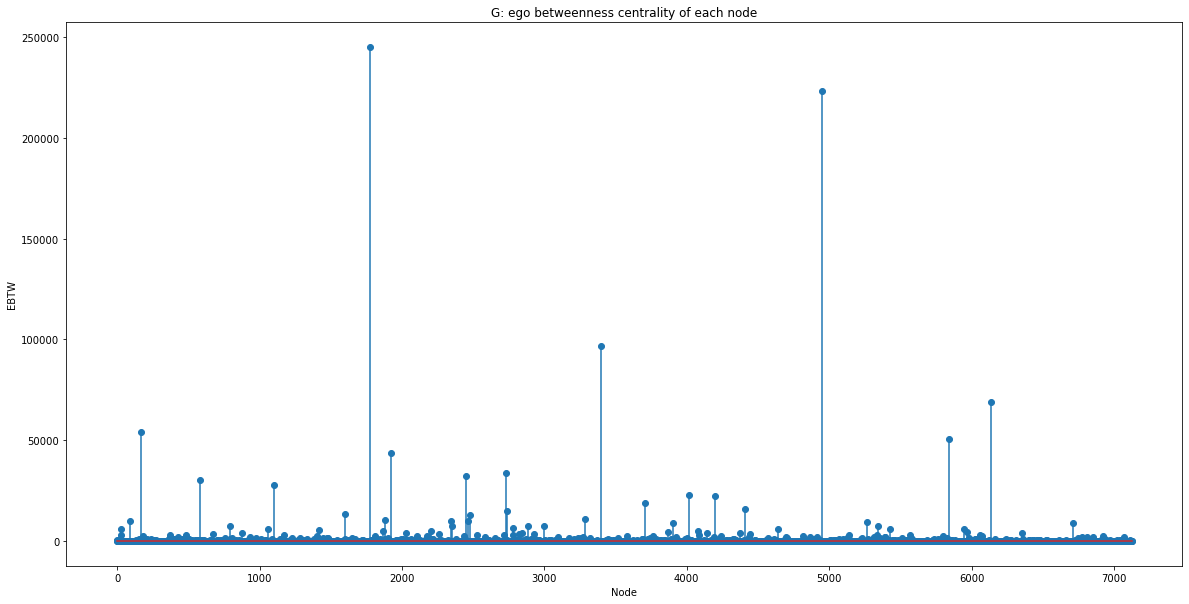

In [20]:
for key in ebtw.keys():
  plt.figure(figsize=(20,10))
  plt.title(key+": ego betweenness centrality of each node")
  plt.xlabel("Node")
  plt.ylabel("EBTW")
  plt.stem(ebtw[key].keys(), ebtw[key].values())

In [21]:
for key in mean_ebtw.keys():
  mean = mean_ebtw[key]
  print("The average ego betweenness centrality is: %f" %mean)

The average ego betweenness centrality is: 248.697331


In [22]:
#insert colors for nodes
from matplotlib import colors as mcolors
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

In [23]:
from itertools import takewhile
#girvan_newman:partitions of at most k=50 communities, select the one with the highest value of modularity.
#use nx.algorithms.community.centrality.girvan_newman for the communities
#nx.algorithms.community.quality.modularity to measure modularity

def comd_GN(G,k):
  best = 0
  best_coms = None
  comp = nx.algorithms.community.centrality.girvan_newman(G)   
  limited = takewhile(lambda c: len(c) <= k, comp)
  for communities in limited:
    com  = tuple(sorted(c) for c in communities) 
    mod = nx.algorithms.community.quality.modularity(G,com)
    if mod>best:
      best = mod
      best_coms = com
  return best_coms

In [24]:
#Spectral Clustering:all partitions of k={1,..50} communities
#use SpectralClustering for the communities
#nx.algorithms.community.quality.modularity to measure modularity

def comd_SP(G,k):
  A = nx.adjacency_matrix(G).todense()
  best = 0
  best_coms = None
  for i in range(1,k+1):
    clustering = SpectralClustering(n_clusters=i).fit(A)
    com = []
    for u in np.unique(clustering.labels_):
      subl = [x for x in range(len(clustering.labels_)) if clustering.labels_[x]==u]
      com.append(subl)
    mod = nx.algorithms.community.quality.modularity(G,com)
    if (mod > best):
      best = mod
      best_coms = com
  return best_coms

In [25]:
#Modularity Maximization
#use nx.algorithms.community.modularity_max.greedy_modularity_communities for the communities
#nx.algorithms.community.quality.modularity to measure modularity

def comd_MM(G):
  return [list(x) for x in nx.algorithms.community.modularity_max.greedy_modularity_communities(G)] 

In [26]:
MM_coms = {
    'G':comd_MM(G)
}

In [27]:
pos = {
  'G':nx.fruchterman_reingold_layout(G)
}

In [28]:
def visual_com(G,nodelist, pos):
  nx.draw_networkx_edges(G, pos=pos)
  for (nodes,i) in zip(nodelist,range(len(nodelist))):
    nx.draw_networkx_nodes(G, pos=pos ,nodelist=nodes ,node_color=colors[i])

In [29]:
def subplots(G,G_name):
  gs = gridspec.GridSpec(2, 2)
  fig = plt.figure(figsize=(20,15))
  ax3 = fig.add_subplot(gs[1, 0])
  visual_com(G,MM_coms[G_name], pos[G_name])
  ax3.set_title('Modularity Maximization')
  plt.show()

In [30]:
def print_mods(G, G_name):
  print("Modularity Maximization: %f" %nx.algorithms.community.quality.modularity(G,MM_coms[G_name]))

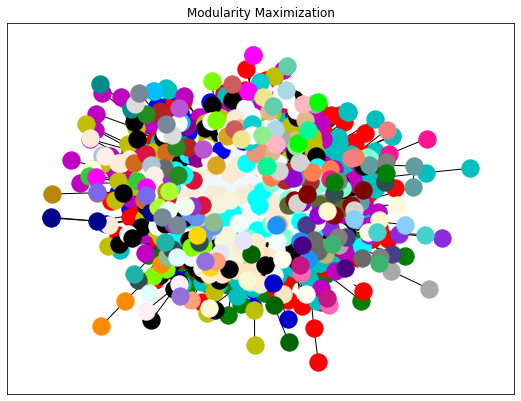

In [31]:
subplots(G,'G')

In [32]:
print("Modularities for the Graph")
print_mods(G,'G')

Modularities for the Graph
Modularity Maximization: 0.419732


In [33]:
nx.to_numpy_matrix(G)

matrix([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
#another Way
print(nx.adjacency_matrix(G).todense())

[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
